## Medial Axis


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid
from skimage.morphology import medial_axis
from skimage.util import invert
from planning import a_star
%matplotlib inline 

In [2]:
plt.rcParams['figure.figsize'] = 12, 12

In [3]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


Starting and goal positions in *(north, east)*.

In [4]:
start_ne = (25,  100)
goal_ne = (650, 500)

In [5]:
# Static drone altitude (meters)
drone_altitude = 5
safety_distance = 2

### Exploring a solution using `numpy` vectorization and broadcasting

A [nice article](https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/) on the topic.

In [6]:
grid = create_grid(data, drone_altitude, safety_distance)
skeleton = medial_axis(invert(grid))


In [7]:
grid.shape

(921, 921)

In [8]:
print(grid[:20][:20])

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


In [9]:
print(skeleton[:20][:20])

[[False False False ...  True  True  True]
 [False False False ... False False  True]
 [False False False ... False False  True]
 ...
 [False False False ... False False  True]
 [False False False ... False False  True]
 [False False False ... False False  True]]


In [10]:
skeleton.nonzero()[:20][:20]

(array([  0,   0,   0, ..., 920, 920, 920]),
 array([ 53,  54,  55, ..., 917, 918, 919]))

In [11]:
np.transpose(skeleton.nonzero())[:20][:20]

array([[ 0, 53],
       [ 0, 54],
       [ 0, 55],
       [ 0, 56],
       [ 0, 57],
       [ 0, 58],
       [ 0, 59],
       [ 0, 60],
       [ 0, 61],
       [ 0, 62],
       [ 0, 63],
       [ 0, 64],
       [ 0, 65],
       [ 0, 66],
       [ 0, 67],
       [ 0, 68],
       [ 0, 69],
       [ 0, 70],
       [ 0, 71],
       [ 0, 72]])

Plot the edges on top of the grid along with start and goal locations.

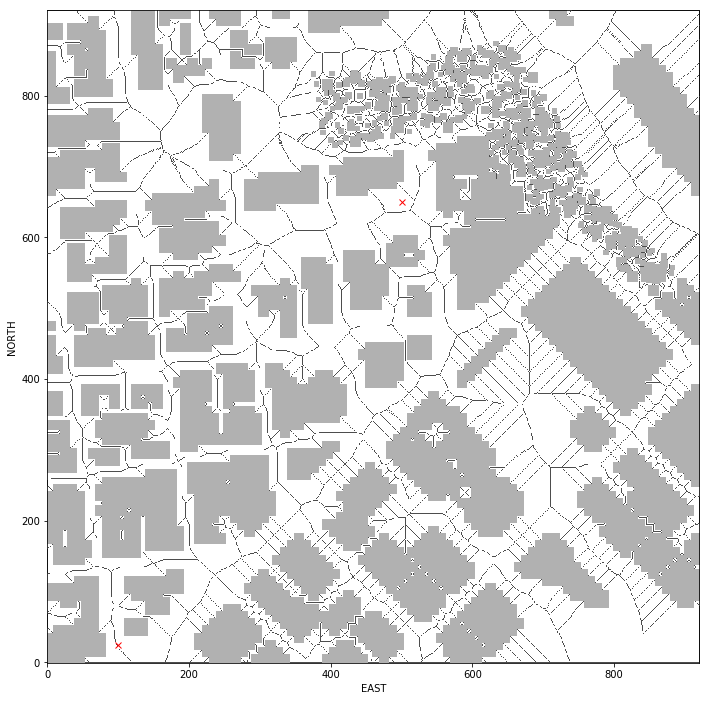

In [7]:
# equivalent to
# plt.imshow(np.flip(grid, 0))

plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
    
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

In [8]:
print(skeleton[:20])

[[False False False ...,  True  True  True]
 [False False False ..., False False  True]
 [False False False ..., False False  True]
 ..., 
 [False False False ..., False False  True]
 [False False False ..., False False  True]
 [False False False ..., False False  True]]


In [9]:
print(grid.shape)

(921, 921)


In [10]:
print(skeleton.shape)

(921, 921)


In [11]:
skeleton[45][90]

False

In [12]:
skeleton[start_ne[0]][start_ne[1]]

False

In [20]:
# TODO: Your start and goal location defined above
# will not necessarily be on the skeleton so you
# must first identify the nearest cell on the 
# skeleton to start and goal

def find_start_goal(skel, start, goal):
    # TODO: find start and goal on skeleton
    # Some useful functions might be:
        # np.nonzero()
        # np.transpose()
        # np.linalg.norm()
        # np.argmin()
    
    # check if a point is on the skeleton
    def on_skel(p):
        return skel[p[0]][p[1]]
    
    # return a square of neighboring points
    # at a radial distance d and centered
    # at p
    def neighbors(p, d):
        neibs = []
        n, e = p
        for y in [-d, d]:
            for x in range(-d, d+1):
                neibs.append((n + y, e + x))
        for x in [-d, d]:
            for y in range(-d+1, d):
                neibs.append((n + y, e + x))               
        return neibs

    # find (one of) the nearest points to p
    # that is on the skeleton
    def find_nearest(p):
        near_p = None
        
        if on_skel(p):
            near_p = p
        else:
            # start at d=1
            # check if any of these neighbors are on the skeleton
            # if yes, set near_p to the closest point, and break
            # if not, d++ and continue
            d = 1
            while True:
                neibs_on_skel = [p for p in neighbors(p, d) if on_skel(p)]
                if len(neibs_on_skel) == 0:
                    d += 1
                    continue
                else:
                    np_start = np.array(p)
                    # near_start is the closest of neibs_on_skel points to start
                    # np.linalg.norm(a-b) is the Euclidean distance b/n a and b
                    # np.linarg(distances) is the index of the nearest point
                    distances = [np.linalg.norm(np_start-np.array(p)) for p in neibs_on_skel]
                    near_p = neibs_on_skel[np.argmin(distances)]
                    break
                    
        return near_p
    
    near_start = find_nearest(start)
    near_goal = find_nearest(goal)

    return near_start, near_goal

skel_start, skel_goal = find_start_goal(skeleton, start_ne, goal_ne)

print(start_ne, goal_ne)
print(skel_start, skel_goal)


(25, 100) (650, 500)
(24, 99) (660, 510)


In [21]:
def heuristic_func(position, goal_position):
    return np.sqrt((position[0] - goal_position[0])**2 + (position[1] - goal_position[1])**2)

### TODO: Run A* on the skeleton
see [planning.py](/edit/planning.py) for a reminder on how to run the imported A* implementation (or rewrite it!)

In [28]:
path1, cost1 = a_star(invert(skeleton).astype(np.int), heuristic_func, tuple(skel_start), tuple(skel_goal))

Found a path.


In [26]:
# Compare to regular A* on the grid
path2, cost2 = a_star(grid, heuristic_func, start_ne, goal_ne)


Found a path.


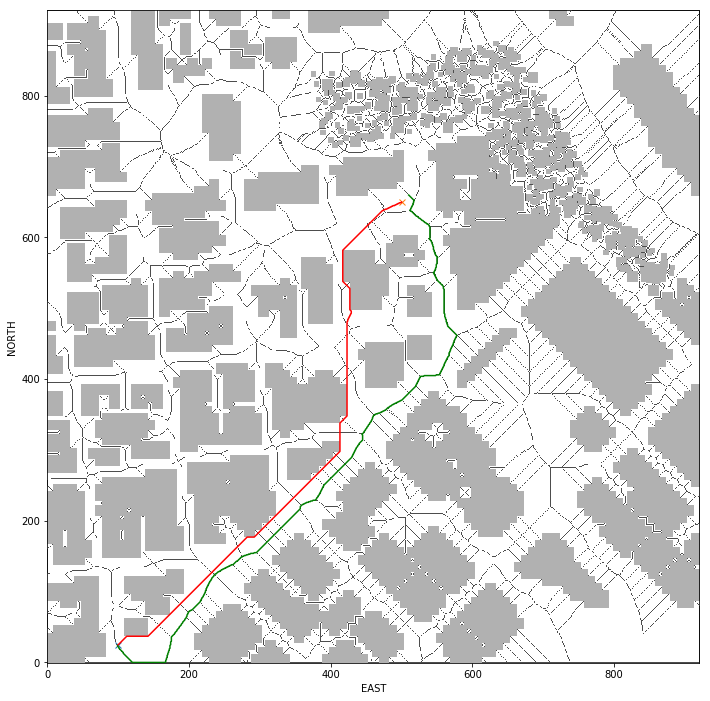

In [29]:
plt.imshow(grid, cmap='Greys', origin='lower')
plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)
# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
# Uncomment the following as needed
plt.plot(goal_ne[1], goal_ne[0], 'x')

pp = np.array(path1)
plt.plot(pp[:, 1], pp[:, 0], 'g')
pp2 = np.array(path2)
plt.plot(pp2[:, 1], pp2[:, 0], 'r')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

[solution](/notebooks/Medial-Axis-Solution.ipynb)